#  Transforming Cylindrical Map Projections

This notebook explains cylindrical map projections and how to change them.

Note from 6/16/2020: this is pretty old and may not run, but some of the plots are interesting (I like the 3d ones) so I'm keeping it in.  I updated it today but just to go from python 2 to 3 and remove some imports.  Really only keeping this for the 3d plots.

In [14]:
%matplotlib inline

from imageio import imread, imwrite
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

First we will just read in and plot a map.

In [15]:
map1 = imread('input_images/small_sat_peters.jpg')

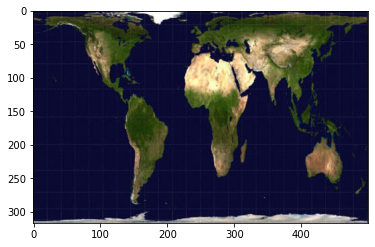

In [16]:
plt.imshow(map1)

Check the size and orientation.

In [17]:
map1.shape

(317, 500, 3)

It's a numpy array.  The first index is across rows, or y-pixels.  The second is columns, or x-pixels.  The third is RGB.

##  The Gall-Peters Projection

This map is made using the [Gall-Peters Projection](https://en.wikipedia.org/wiki/Gall%E2%80%93Peters_projection).  It is a cylindrical projection preserving equal areas.  

Mathematically, we can get a pixel left-right location $u$ and up-down location $v$ using 

\begin{eqnarray}
u &=& \frac{R}{\sqrt{2}} \lambda \\
v &=& R \sqrt{2} \sin{\phi} \\
\end{eqnarray}

Where $\lambda$ is longitude in radians, from $-\pi$ at the left end of the map, to $0$ in London and $\pi$ on the right side of this map.  $\phi$ is latitude, from $-\frac{\pi}{2}$ on the South pole, and $\frac{\pi}{2}$ on the North pole. 

Here, $R$ is the radius is a model globe for the projection.  In our case, we'll use $R = 1.0$.  We may also later want to choose an $R$ denominated in pixels, to make some conversions easier.

With these equations we can go backwards from pixel values to longitudes and latitudes using 

\begin{eqnarray}
\lambda &=& \frac{\sqrt{2}{R}} u \\
\phi &=& \arcsin{ ( \frac{1}{R \sqrt{2} } v )} \\
\end{eqnarray}

Let's compute these for our map and confirm they make sense to us.

In [18]:
(ny, nx, _) = map1.shape
xs, ys = np.meshgrid(np.arange(0, nx), np.arange(0, ny))
xs = xs.flatten().astype(float)
ys = ys.flatten().astype(float)

print(f' xs has shape {xs.shape} and range {(np.amin(xs), np.amax(xs))}')
print(f' ys has shape {ys.shape} and range {(np.amin(ys), np.amax(ys))}')

 xs has shape (158500,) and range (0.0, 499.0)
 ys has shape (158500,) and range (0.0, 316.0)


Good, so now we have a grid of xs and a grid of ys for our pixel values $u$ and $v$.  

In [19]:
mapdims = (nx, ny)
print(f'mapdims are {mapdims}')

#  Pixel values are from 0 to N, so we need to do
#  some trickery to map them to (-pi,pi) and (-pi/2, pi/2)
def longitudeAndLatitudeFromGPPixel(x, y, mapdims):
    nx, ny = mapdims
    longitude = x * ( 2* np.pi / float(nx))  - np.pi
    latitude = np.arcsin(2.0 * ( (y / ny) - (0.5)) )
    return(longitude, latitude)

mapdims are (500, 317)


Let's confirm this worked by plotting the longitude and latitude.

In [20]:
longitude, latitude = longitudeAndLatitudeFromGPPixel(xs, ys, mapdims)
longitude_range = (np.amin(longitude), np.amax(longitude))
print(f'range of longitudes is {longitude_range}')

range of longitudes is (-3.141592653589793, 3.1290262829754347)


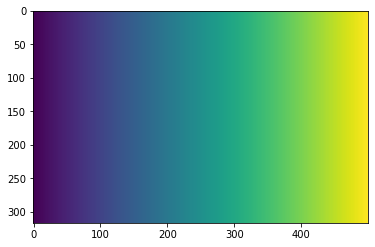

In [21]:
map_longs = deepcopy(longitude)
map_longs.shape = (ny, nx)

plt.imshow(map_longs, clim = (-np.pi, np.pi))

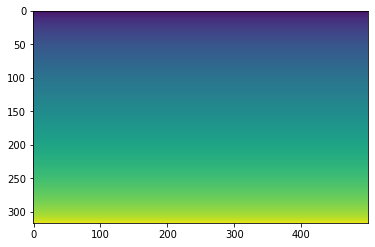

In [22]:
map_lats = deepcopy(latitude)
map_lats.shape = (ny, nx)

plt.imshow(map_lats, clim = (-np.pi/2, np.pi/2))

Looks great!

##  Longitude and Latitude to Globe

Now, with $\lambda$ and $\phi$, we want to go to a 3D $\vec{x}$ position on the globe.  We will then rotate the globe to get _new_ longitudes and latitudes.

We can get 3D locations using 

\begin{eqnarray}
x &=& \cos{\lambda} * \cos{\phi} \\
y &=& \sin{\lambda} * \sin{\phi} \\
z &=& \sin{\phi} \\
\end{eqnarray}

Let's do this for our map and confirm it makes sense.

In [23]:
def spatialCoordinatesFromLongitudeAndLatitude(longitude, latitude):
    x = np.cos(longitude) * np.cos(latitude)
    y = np.sin(longitude) * np.cos(latitude)
    z = np.sin(latitude)
    return(x, y, z)

In [24]:
xxs, yys, zzs = spatialCoordinatesFromLongitudeAndLatitude(longitude, latitude)

And now let's map them to make sure they're reasonable.

In [25]:
def map_output(output, clim):
    output.shape = (ny, nx)
    plt.imshow(output, clim = clim)

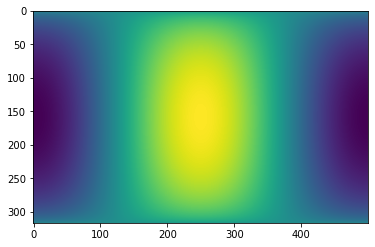

In [26]:
map_output(xxs, (-1.0, 1.0))

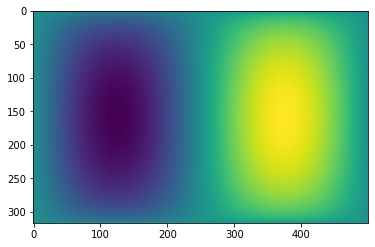

In [27]:
map_output(yys, (-1.0, 1.0))

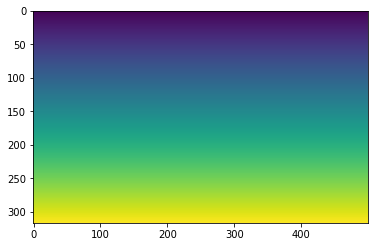

In [28]:
map_output(zzs, (-1.0, 1.0))

Cool!  All basically makes sense.  

Let's now see if we can actually plot a globe.  It might make the rotation bit much clearer.

In [29]:
long_col = deepcopy(longitude)
long_col.shape = xxs.shape


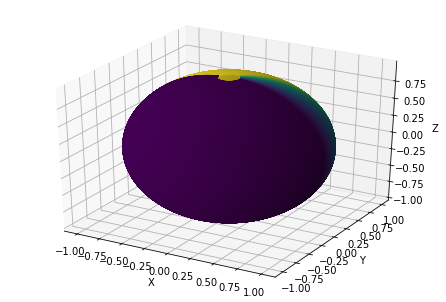

In [30]:
from matplotlib import cm

import pylab as pylab
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

fig=pylab.figure()
ax = p3.Axes3D(fig)
ax.plot_surface(xxs, yys, zzs, 
               rstride=1, cstride=1,
                facecolors=cm.viridis(long_col), vmin = -np.pi, vmax = np.pi)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pylab.show()

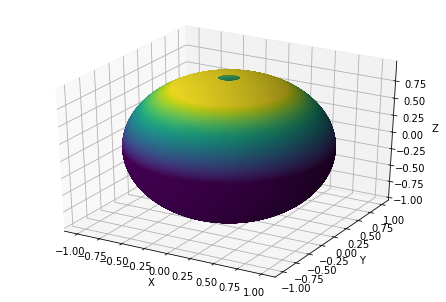

In [31]:
lat_col = deepcopy(latitude)
lat_col.shape = xxs.shape


from matplotlib import cm

import pylab as pylab
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

fig=pylab.figure()
ax = p3.Axes3D(fig)
ax.plot_surface(xxs,yys,zzs, 
               rstride=1, cstride=1,
                facecolors=cm.viridis(lat_col), vmin = -np.pi/2, vmax = np.pi/2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pylab.show()

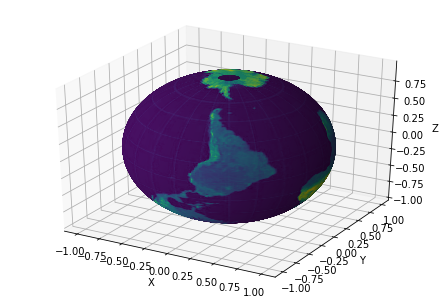

In [32]:
fig=pylab.figure()
ax = p3.Axes3D(fig)
ax.plot_surface(xxs,yys,zzs, 
               rstride=1, cstride=1,
                facecolors=cm.viridis(np.squeeze(map1[:, :, 1])), vmin = 0, vmax = 255)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pylab.show()

Neat!  Although, this globe is clearly upside down.  But we have 3D plotting!

It appears as though my $Z$ axis has the South pole at the top.  Then I have the Americas at negative $Y$ values, and Europe and Asia at postive $Y$ values.  Africa has a positive $X$ and Europe a negative $X$.

##  Rotating the Globe!

This is just a standard rotation using a matrix multiplication.

In [33]:
from map_projections.projections import rotationFromXYZ

In [34]:
rotation_matrix = rotationFromXYZ(0.0, 0.0, np.pi)
rotation_matrix

matrix([[-1.0000000e+00, -1.2246468e-16,  0.0000000e+00],
        [ 1.2246468e-16, -1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

Now we apply this transformation to our spatial locations.

In [35]:
xxs = xxs.ravel()
yys = yys.ravel()
zzs = zzs.ravel()

new_xxyyzz = np.dot(rotation_matrix, np.array([xxs, yys, zzs]))
    
new_xxs = np.squeeze(np.array(new_xxyyzz[0, :]))
new_yys = np.squeeze(np.array(new_xxyyzz[1, :]))
new_zzs = np.squeeze(np.array(new_xxyyzz[2, :]))

new_xxs.shape

(158500,)

Now let's see if it worked by plotting our original map onto our _new_ spatial coordinates.

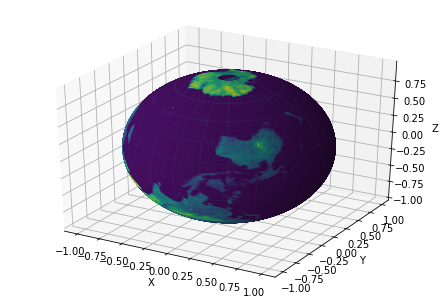

In [36]:
new_xxs.shape = (ny, nx)
new_yys.shape = (ny, nx)
new_zzs.shape = (ny, nx)


fig=pylab.figure()
ax = p3.Axes3D(fig)
ax.plot_surface(new_xxs,new_yys,new_zzs, 
               rstride=1, cstride=1,
                facecolors=cm.viridis(np.squeeze(map1[:, :, 1])), vmin = 0, vmax = 255)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pylab.show()

And now our globe has been rotated!

##  From New Coordinates back to Longitude and Latitude

We originally went from $\lambda$ and $\phi$ to $\vec{x}$ using

\begin{eqnarray}
x &=& \cos{\lambda} * \cos{\phi} \\
y &=& \sin{\lambda} * \sin{\phi} \\
z &=& \sin{\phi} \\
\end{eqnarray}.

Now we can easily recover $\phi$ with $\phi = \arcsin{z}$.  $\lambda$ is a bit harder, but we can use `np.arctan2`, which is an arctangent that returns our desired sign.  

In [37]:
def longitudeAndLatitudeFromSpatialCoordinates(xxs, yys, zzs):
    latitude = np.arcsin(zzs)
    longitude = np.arctan2(yys, xxs)

    #  Now we need to put longitude onto the (-pi, pi) scale
    #  rather than the (0, 2*pi) scale.
    need_to_be_flipped = np.greater(longitude, np.pi)
    longitude = longitude - need_to_be_flipped * (longitude) - need_to_be_flipped * (2*np.pi - longitude)

    return((longitude, latitude))

In [38]:
new_longitude, new_latitude = longitudeAndLatitudeFromSpatialCoordinates(
    new_xxs, new_yys, new_zzs)

Now let's look at the new longitudes and latitudes to just confirm they make sense.  

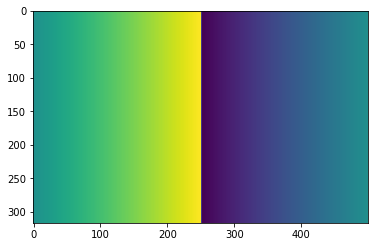

In [39]:
map_output(new_longitude, (-np.pi, np.pi))

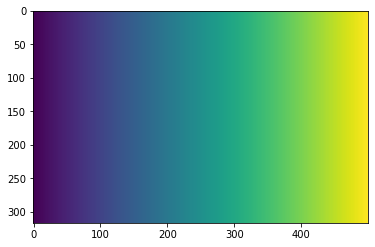

In [40]:
map_output(longitude, (-np.pi, np.pi))

Looks about right.  Our rotation was very simple, just a flip.

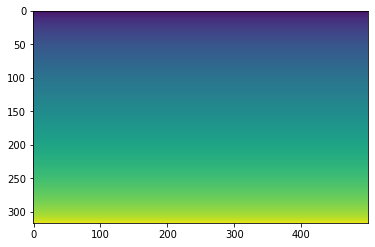

In [41]:
map_output(new_latitude, (-np.pi/2, np.pi/2))

Latitudes look good, but longitudes might be off.  

##  From Longitude and Latitude back to Pixels

Now, we can use the first formulas we introduced, 
\begin{eqnarray}
u &=& \frac{R}{\sqrt{2}} \lambda \\
v &=& R \sqrt{2} \sin{\phi} \\
\end{eqnarray}.


In [42]:
def gall_peters_pixels(longitude, latitude, mapdims):
    nx, ny = mapdims
    
    u = nx * (0.5 + (longitude / (2*np.pi)))
    v = (ny/2) * (np.sin(latitude)+1.0)
    
    u = u.astype(int)
    v = v.astype(int)
    
    u[u == nx] = nx - 1
    v[v == ny] = ny - 1
    
    return((u, v))

In [43]:
new_us, new_vs = gall_peters_pixels(new_longitude, new_latitude, mapdims)

Now we can use these pixels in the new mapping.

0 499
0 316


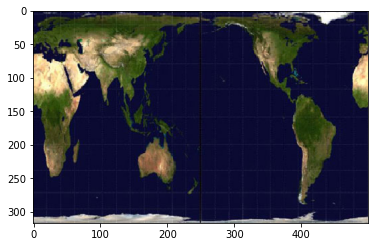

In [44]:
new_us.shape = (ny, nx)
new_vs.shape = (ny, nx)

print (np.amin(new_us), np.amax(new_us))
print (np.amin(new_vs), np.amax(new_vs))

new_map = deepcopy(map1)
new_map[:, :, 0] = map1[new_vs, new_us, 0]
new_map[:, :, 1] = map1[new_vs, new_us, 1]
new_map[:, :, 2] = map1[new_vs, new_us, 2]
    
plt.imshow(new_map)

# Everything at Once

In [45]:
rot = rotationFromXYZ(np.pi/5, -np.pi/3, 1.3*np.pi)

from map_projections.projections import transform_map

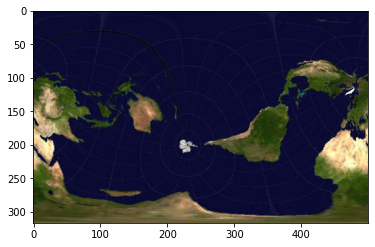

In [46]:
newmap = transform_map(map1, rot, debug = False)